In [2]:
from Ajedrez import Ajedrez,train
from SplitImageDataset import SplitImageDataset
from WholeImageDataset import WholeImageDataset

import chess

import numpy as np
import torch
from torch import nn
from torch import optim
import matplotlib.pyplot as plt
import math
import time
import random

import torch.optim
from tqdm.notebook import tqdm

import DataUtils

import sys
sys.path.append("../engines")

from ChessEngine import ChessEngine

from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader, random_split

from PIL import Image
from skimage import io

from sklearn.metrics import confusion_matrix

import seaborn as sns

%load_ext autoreload
%autoreload 2

## Visualizing Data

## Training AJ

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

AJ = Ajedrez(3, continue_training=True).to(device)

In [ ]:
color_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
depth_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=0, std=1)
])

# DATA_SIZE = 55_000
# TRAIN_SIZE = 38_500
# TEST_SIZE = 16_500

DATA_SIZE = 11_000
TRAIN_SIZE = 8_000
TEST_SIZE = 3_000

dset = SplitImageDataset('./image_dataset/metadata.csv',
    dataset_size=DATA_SIZE,
    use_depth=False,
    color_transform=color_transforms, 
    depth_transform=depth_transforms,
)

train_data, test_data = random_split(dset, [TRAIN_SIZE, TEST_SIZE])

train_loader = DataLoader(train_data, batch_size=20, 
                          shuffle=True, num_workers=2)
test_loader = DataLoader(test_data, batch_size=20, 
                         shuffle=False, num_workers=2)

sgd = optim.SGD(AJ.parameters(), lr=0.001, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(sgd, step_size=2, gamma=0.1)

NUM_EPOCHS = 1

train_loss, test_loss = train(AJ, train_loader, 
                              test_loader, sgd, 
                              scheduler, device, NUM_EPOCHS)

# torch.save(AJ.state_dict(), './aj_model.pt')
# torch.cuda.empty_cache()

In [ ]:
fig = plt.figure()

ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()

ax1.plot(train_loss[0], train_loss[1], 'r', linewidth=1)
ax1.set_xlabel("Steps in Training")

ax2.plot(test_loss[0], test_loss[1], 'g', linewidth=2)
ax2.set_xlabel("Epochs in Testing")
ax2.set_xticks(np.arange(NUM_EPOCHS+1))

plt.show()

## Visual Test of AJ

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

AJ = Ajedrez(3, continue_training=False).to(device)

In [ ]:
color_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

print(f'Retrieving One Item')

dset_full = WholeImageDataset('./image_dataset/metadata.csv',
    color_transform=color_transforms,
    dataset_size=1100
)

color_img, concat_img = dset_full[0] 

plt.figure(figsize=(15,15))
plt.axis('off')
plt.imshow(color_img)

AJ.load_state_dict(torch.load('./aj_model.pt'))
AJ.eval()

concat_img = concat_img.to(device)    
out_c = AJ.forward(concat_img)

classes = out_c.argmax(1)

print(classes)
print(classes.shape)

board = chess.Board(None)

nrow = 8
ncol = 8

for i in range(nrow):
    for j in range(ncol):
        rank = chess.RANK_NAMES[7 - i]
        file = chess.FILE_NAMES[j]
        
        square = chess.parse_square(file + rank)
        
        piece = ChessEngine.numberToPiece(classes[i*ncol+j].item())
        
        if piece is not None:
            board.set_piece_at(square, piece)
            
board

### Split Image Directly

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

AJ = Ajedrez(3, continue_training=False).to(device)

AJ.load_state_dict(torch.load('./aj_model.pt'))
AJ.eval()

print('Done!')

In [ ]:
color_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

img = io.imread('image_dataset/rectified/000000.png')

concat_img = DataUtils.split_image_pytorch(img, color_transforms).to(device)

out_c = AJ.forward(concat_img)

classes = out_c.argmax(1)

board = chess.Board(None)

nrow = 8
ncol = 8

for i in range(nrow):
    for j in range(ncol):
        rank = chess.RANK_NAMES[7 - i]
        file = chess.FILE_NAMES[j]
        
        square = chess.parse_square(file + rank)
        
        piece = ChessEngine.numberToPiece(classes[i*ncol+j].item())
        
        if piece is not None:
            board.set_piece_at(square, piece)
            
board

### Build Confusion Matrix

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

AJ = Ajedrez(3, continue_training=False).to(device)

AJ.load_state_dict(torch.load('./aj_model.pt'))
AJ.eval()

print('Done!')

Done!


In [5]:
ALL_LABELS = np.arange(13).astype(np.uint8)

color_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
depth_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=0, std=1)
])

DATA_SIZE = 11_000

dset = SplitImageDataset('./image_dataset/metadata.csv',
    dataset_size=DATA_SIZE,
    use_depth=False,
    color_transform=color_transforms, 
    depth_transform=depth_transforms,
)

data_loader = DataLoader(dset, batch_size=20, 
                         shuffle=False, num_workers=2)

c_matrix = None

for imgs,labels in tqdm(data_loader):
    imgs = imgs.to(device)
    
    preds = AJ.forward(imgs).argmax(1).cpu().numpy()
    
    if c_matrix is None:
        c_matrix = confusion_matrix(y_true=labels.numpy(), 
                                    y_pred=preds, labels=ALL_LABELS)
    else:
        c_matrix += confusion_matrix(y_true=labels.numpy(), 
                                     y_pred=preds, labels=ALL_LABELS)

In [6]:
c_matrix

array([[ 997,    0,    0,    0,    0,    0,    0,    0,    1,    0,    0,
           2,    0],
       [   0,  998,    0,    0,    0,    0,    1,    0,    0,    0,    0,
           1,    0],
       [   0,    0,  998,    0,    0,    0,    0,    0,    1,    0,    0,
           1,    0],
       [   0,    0,    0,  998,    0,    1,    0,    0,    1,    0,    0,
           0,    0],
       [   0,    0,    0,    1,  999,    0,    0,    0,    0,    0,    0,
           0,    0],
       [   0,    0,    0,    0,    0,  499,    1,    0,    0,    0,    0,
           0,    0],
       [   0,    0,    0,    0,    0,   37,  462,    0,    0,    0,    0,
           0,    1],
       [   0,    0,    0,    0,    0,    0,    0,  999,    1,    0,    0,
           0,    0],
       [   0,    0,    0,    0,    0,    2,    0,    0,  998,    0,    0,
           0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,  999,    0,
           1,    0],
       [   0,    0,    0,    0,    0,    0,    0, 

<AxesSubplot:>

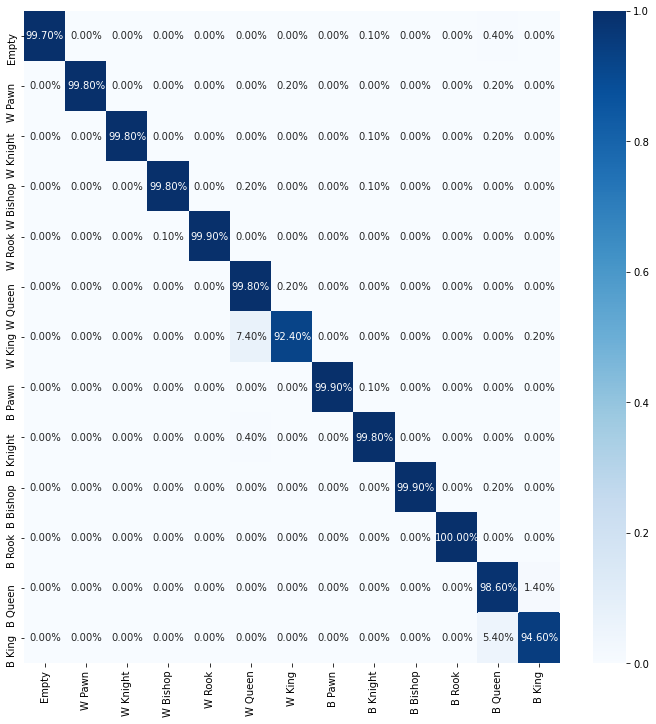

In [19]:
piece_labels = ['Empty', 
                'W Pawn', 'W Knight', 'W Bishop', 'W Rook', 'W Queen', 'W King', 
                'B Pawn', 'B Knight', 'B Bishop', 'B Rook', 'B Queen', 'B King']

fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(c_matrix/c_matrix.sum(axis=1), 
            ax=ax, annot=True, cmap='Blues', fmt='.2%',
            xticklabels=piece_labels, yticklabels=piece_labels)